In [1]:
import otagrum

import openturns as ot

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

In [2]:
bn = gum.BayesNet.fastPrototype('A->B->C;D->E')
bn

(gum::BayesNet<double>@0x55a76810a980) BN{nodes: 5, arcs: 3, domainSize: 32, parameters: 16, compression ratio: 50% }

In [34]:
ndag=otagrum.NamedDAG(bn)
order=ndag.getTopologicalOrder()

jointDistributions=[]
for i in range(order.getSize()):
    d = 1 + ndag.getParents(i).getSize()
    #R = ot.CorrelationMatrix(d)
    #for i in range(d):
    #    for j in range(i):
    #        R[i, j] = 0.8
    #jointDistributions.append(ot.Student(5.0, [0.0]*d, [1.0]*d, R).getCopula())
    jointDistributions.append(ot.Dirichlet([(1.0+k)/(d+1) for k in range(d+1)]).getCopula())
    
copula = otagrum.ContinuousBayesianNetwork(ndag, jointDistributions)
sample = copula.getSample(15000)
learner=otagrum.ContinuousPC(sample)
g=learner.inferSkeleton()
print(learner.inferPDAG(g))
gnb.sideBySide(bn,gnb.getDot(g.toDot()),gnb.getDot(learner.learnDAG().toDot()))

{0,1,2,3,4} , {} , {0--2,1--2,3--4}


G <!-- A --> A A <!-- B --> B B <!-- A->B --> A->B <!-- C --> C C <!-- B->C --> B->C <!-- D --> D D <!-- E --> E E <!-- D->E --> D->E,no_name <!-- 0 --> 0 0 <!-- 2 --> 2 2 <!-- 0->2 --> 0->2 <!-- 1 --> 1 1 <!-- 1->2 --> 1->2 <!-- 3 --> 3 3 <!-- 4 --> 4 4 <!-- 3->4 --> 3->4,G <!-- D --> D D <!-- E --> E E <!-- D->E --> D->E <!-- C --> C C <!-- B --> B B <!-- C->B --> C->B <!-- A --> A A <!-- A->C --> A->C


In [35]:
for s in learner.getTrace():
    print(s)

000 :        A-D|                      p=0.993131    ttest=-0.00860924
001 :        B-D|                      p=0.919693    ttest=-0.100821
002 :        C-D|                      p=0.972191    ttest=-0.0348601
003 :        A-E|                      p=0.996902    ttest=0.0038831
004 :        B-E|                      p=0.98999     ttest=-0.0125465
005 :        C-E|                      p=0.996333    ttest=0.00459542
006 :        A-B|C                     p=0.927669    ttest=0.0907778


In [67]:
test=otagrum.ContinuousTTest(sample)
print(test.isIndep(0,2,[]))
print(test.isIndep(0,1,[]))

(14.368316373769543, 8.179559168475664e-47, False)
(77.2975999315883, 0.0, False)


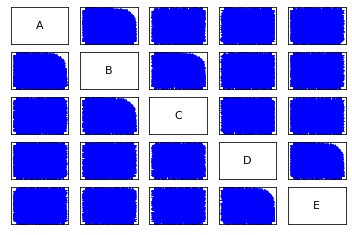

In [25]:
ot.Show(ot.Pairs(sample))

In [26]:
print(sample.computeSpearmanCorrelation())

5x5
[[  1           -0.147802     0.0344033    0.000103025 -0.000319092 ]
 [ -0.147802     1           -0.152425     0.0105742   -0.00368864  ]
 [  0.0344033   -0.152425     1           -0.0254192    0.00807354  ]
 [  0.000103025  0.0105742   -0.0254192    1           -0.150577    ]
 [ -0.000319092 -0.00368864   0.00807354  -0.150577     1           ]]


In [27]:
print("\n".join([str(d) for d in jointDistributions]))

IndependentCopula(dimension = 1)
class=SklarCopula name=SklarCopula dimension=2 distribution=class=Dirichlet name=Dirichlet dimension=2 theta=class=Point name=Unnamed dimension=3 values=[0.333333,0.666667,1.66667]
class=SklarCopula name=SklarCopula dimension=2 distribution=class=Dirichlet name=Dirichlet dimension=2 theta=class=Point name=Unnamed dimension=3 values=[0.333333,0.666667,1.66667]
IndependentCopula(dimension = 1)
class=SklarCopula name=SklarCopula dimension=2 distribution=class=Dirichlet name=Dirichlet dimension=2 theta=class=Point name=Unnamed dimension=3 values=[0.333333,0.666667,1.66667]


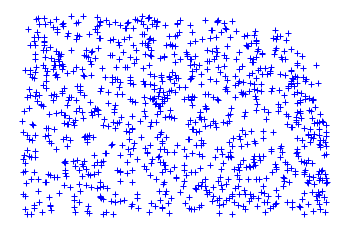

In [28]:
student = jointDistributions[1]
ot.Show(ot.Cloud(student.getCopula().getSample(1000)))

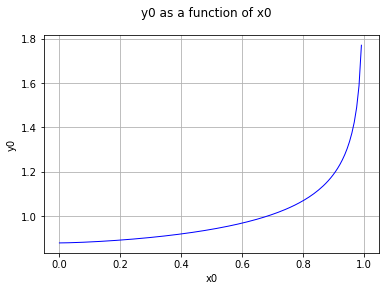

In [29]:
a=0.2
def f(x):
    return [student.getCopula().computeConditionalPDF(x[0], [a])]
fot = ot.PythonFunction(1,1,f)
ot.Show(fot.draw(0.0+1e-6,1.0-1e-6))

In [51]:
sample1=sample[0:5000]
bw=ot.KernelSmoothing().computeSilvermanBandwidth(sample1.getMarginal([0,1,2]))
print(bw)
j01=ot.KernelSmoothing().build(sample1.getMarginal([0,1]), bw[0:2])
j12=ot.KernelSmoothing().build(sample1.getMarginal([1,2]), bw[1:])
j012=ot.KernelSmoothing().build(sample1.getMarginal([0,1,2]), bw)
j1=ot.KernelSmoothing().build(sample1.getMarginal([1]), bw[0:1])

[0.109517,0.0829085,0.087848]


In [52]:
s01=j01.computePDF(sample.getMarginal([0,1]))
s12=j12.computePDF(sample.getMarginal([1,2]))
s012=j012.computePDF(sample.getMarginal([0,1,2]))
s1=j1.computePDF(sample.getMarginal([1]))

In [53]:
ratio=[[s01[i,0]*s12[i,0]/s012[i,0]/s1[i,0]] for i in range(s01.getSize())]

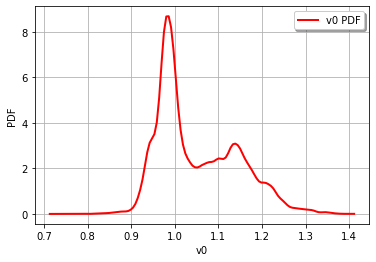

In [54]:
ot.Show(ot.KernelSmoothing().build(ratio).drawPDF())

[0.109517,0.0829085,0.087848]


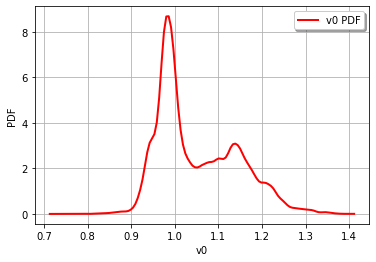

In [62]:
bw=ot.KernelSmoothing().computeSilvermanBandwidth(sample1.getMarginal([0,1,2]))
print(bw)
j02=ot.KernelSmoothing().build(sample1.getMarginal([0,1]), [bw[0]]+[bw[2]])
j12=ot.KernelSmoothing().build(sample1.getMarginal([1,2]), bw[1:])
j012=ot.KernelSmoothing().build(sample1.getMarginal([0,1,2]), bw)
j2=ot.KernelSmoothing().build(sample1.getMarginal([1]), bw[2:])

s02=j01.computePDF(sample.getMarginal([0,2]))
s12=j12.computePDF(sample.getMarginal([1,2]))
s012=j012.computePDF(sample.getMarginal([0,1,2]))
s2=j1.computePDF(sample.getMarginal([2]))

ratio=[[s01[i,0]*s12[i,0]/s012[i,0]/s1[i,0]] for i in range(s01.getSize())]

ot.Show(ot.KernelSmoothing().build(ratio).drawPDF())

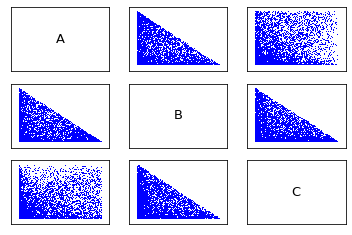

In [66]:
pairs=ot.Pairs(sample1.getMarginal([0,1,2]))
pairs.setPointStyle("dot")
ot.Show(pairs)

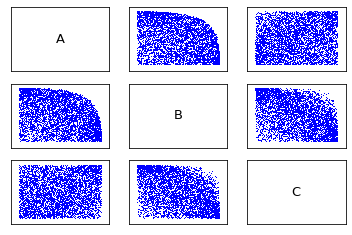

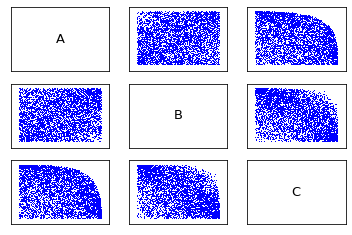

In [14]:
def buildSam(s):
    bn = gum.BayesNet.fastPrototype(s)
    ndag=otagrum.NamedDAG(bn)
    order=ndag.getTopologicalOrder()

    jointDistributions=[]
    for i in range(order.getSize()):
        d = 1 + ndag.getParents(i).getSize()
        jointDistributions.append(ot.Dirichlet([(1.0+k+i)/(d+1) for k in range(d+1)]).getCopula())
    
    copula = otagrum.ContinuousBayesianNetwork(ndag, jointDistributions)
    return copula.getSample(5000)

sample1=buildSam('A->B->C')
sample2=buildSam('A->C->B').getMarginal([0,2,1])

pairs1=ot.Pairs(sample1)
pairs1.setPointStyle("dot")
ot.Show(pairs1)

pairs2=ot.Pairs(sample2)
pairs2.setPointStyle("dot")
ot.Show(pairs2)

In [15]:
def indep(x,y,z=[]):
    print("==")
    print(otagrum.ContinuousTTest(sample1).isIndep(x,y,z))
    print(otagrum.ContinuousTTest(sample2).isIndep(x,y,z))

In [17]:
indep(1,2,[0])
indep(0,1,[2])

==
(0.21421095073701366, 0.8303825568296407, True)
(0.21421095073701366, 0.8303825568296407, True)
==
(0.21421095073701366, 0.8303825568296407, True)
(0.21421095073701366, 0.8303825568296407, True)


In [19]:
c01=ot.BernsteinCopulaFactory().build(sample1.getMarginal([0,1]))
c02=ot.BernsteinCopulaFactory().build(sample1.getMarginal([0,2]))
c12=ot.BernsteinCopulaFactory().build(sample1.getMarginal([1,2]))


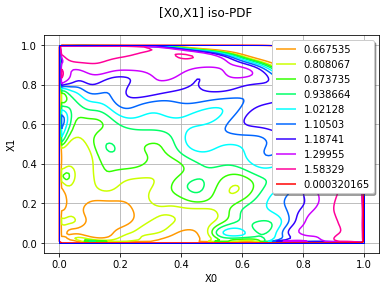

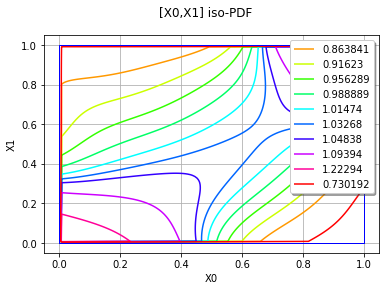

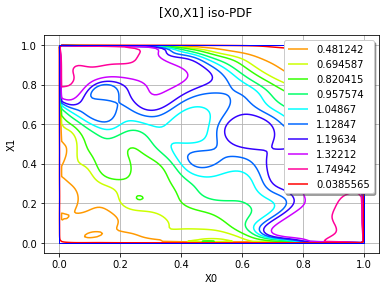

In [21]:
ot.Show(c01.drawPDF())
ot.Show(c02.drawPDF())
ot.Show(c12.drawPDF())